# Section 5: Model Comparison and Diagnostics

#### PyData London 2025 - Bayesian Time Series Analysis with PyMC

---

## Why Model Diagnostics Matter

Model diagnostics are crucial for ensuring that:
- **MCMC chains have converged** to the target distribution
- **Models fit the data appropriately** without systematic biases
- **Model assumptions are reasonable** for the given data
- **Model selection is based on sound criteria** rather than just fit

### The Bayesian Workflow

1. **Build model** → 2. **Check convergence** → 3. **Validate fit** → 4. **Compare models** → 5. **Iterate**

This iterative process ensures robust, reliable models.

In [1]:
# Import necessary libraries for Section 5
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import warnings
from scipy import stats

# Configure plotting and suppress warnings
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
RANDOM_SEED = 42

print("🔧 Section 5 libraries loaded successfully!")
print("Ready to diagnose and compare Bayesian time series models")

🔧 Section 5 libraries loaded successfully!
Ready to diagnose and compare Bayesian time series models


In [2]:
# Load data and build several models for comparison
births_data = pl.read_csv('../data/births.csv', null_values=['null', 'NA', '', 'NULL'])
births_data = births_data.filter(pl.col('day').is_not_null())

monthly_births = (births_data
    .group_by(['year', 'month'])
    .agg(pl.col('births').sum())
    .sort(['year', 'month'])
)

births_subset = (monthly_births
    .filter((pl.col('year') >= 1970) & (pl.col('year') <= 1990))
    .with_row_index('index')
)

original_data = births_subset['births'].to_numpy()
births_standardized = (original_data - original_data.mean()) / original_data.std()
n_obs = len(births_standardized)

print(f"📊 Data prepared: {n_obs} observations")

📊 Data prepared: 228 observations


## Building Models for Comparison

Let's build several models that we can compare and diagnose.

In [3]:
# Model 1: Simple Normal Model (baseline)
with pm.Model() as normal_model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=births_standardized)
    trace_normal = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, chains=2)
    # Add log-likelihood computation for model comparison
    pm.compute_log_likelihood(trace_normal)

# Model 2: AR(1) Model - correctly sized
with pm.Model() as ar1_model:
    rho = pm.Beta('rho', alpha=1, beta=1)
    phi = pm.Deterministic('phi', 2 * rho - 1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    # AR with steps=n_obs-1 produces output of length n_obs
    ar1 = pm.AR('ar1', rho=phi, sigma=sigma, constant=False, 
                init_dist=pm.Normal.dist(mu=0, sigma=1), steps=n_obs-1)
    obs = pm.Normal('obs', mu=ar1, sigma=0.1, observed=births_standardized)
    trace_ar1 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, chains=2)
    # Add log-likelihood computation for model comparison
    pm.compute_log_likelihood(trace_ar1)

# Model 3: Random Walk Model
with pm.Model() as rw_model:
    sigma_walk = pm.HalfNormal('sigma_walk', sigma=1.0)
    init_dist = pm.Normal.dist(mu=0, sigma=1)
    walk = pm.GaussianRandomWalk('walk', mu=0, sigma=sigma_walk, 
                                init_dist=init_dist, steps=n_obs-1)
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1.0)
    obs = pm.Normal('obs', mu=walk, sigma=sigma_obs, observed=births_standardized)
    trace_rw = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, chains=2)
    # Add log-likelihood computation for model comparison
    pm.compute_log_likelihood(trace_rw)

print("✅ Built three models for comparison")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rho, sigma, ar1]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

Initializing NUTS using jitter+adapt_diag...
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_subtensor_merge
ERROR (pytensor.graph.rewriting.basic): node: Subtensor{i}(Subtensor{start:stop}.0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/var/home/fonnesbeck/repos/ts_pydata_london_2025/.pixi/envs/default/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/var/home/fonnesbeck/repos/ts_pydata_london_2025/.pixi/envs/default/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/var/home/fonnesbeck/repos/ts_pydata_london_2025/.pixi/envs/default/lib/python3.13/site-packages/pytensor/tensor/rewriting/subtensor.py", line 542, in local_subtensor_merge
    merge_two_slice

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✅ Built three models for comparison


## 1. Convergence Diagnostics

Before interpreting results, we must ensure that MCMC chains have converged to the target distribution.

### Key Metrics

- **R-hat (Gelman-Rubin statistic)**: Should be < 1.01 for convergence
- **Effective Sample Size (ESS)**: Should be > 400 for reliable inference
- **Monte Carlo Standard Error**: Should be small relative to posterior SD

In [4]:
# Check convergence diagnostics for all models
models_traces = {
    'Normal Model': trace_normal,
    'AR(1) Model': trace_ar1,
    'Random Walk': trace_rw
}

print("🔍 **Convergence Diagnostics**")
print("="*50)

for name, trace in models_traces.items():
    print(f"\n**{name}**:")
    summary = az.summary(trace)
    
    # Check R-hat values
    max_rhat = summary['r_hat'].max()
    print(f"   Max R-hat: {max_rhat:.4f} {'✅' if max_rhat < 1.01 else '❌'}")
    
    # Check effective sample size
    min_ess = summary['ess_bulk'].min()
    print(f"   Min ESS: {min_ess:.0f} {'✅' if min_ess > 400 else '❌'}")
    
    # Check for divergences
    divergences = trace.sample_stats.diverging.sum().values
    print(f"   Divergences: {divergences} {'✅' if divergences == 0 else '❌'}")

🔍 **Convergence Diagnostics**

**Normal Model**:
   Max R-hat: 1.0000 ✅
   Min ESS: 1820 ✅
   Divergences: 0 ✅

**AR(1) Model**:
   Max R-hat: 1.0100 ❌
   Min ESS: 1582 ✅
   Divergences: 0 ✅

**Random Walk**:
   Max R-hat: 1.0100 ❌
   Min ESS: 501 ✅
   Divergences: 0 ✅


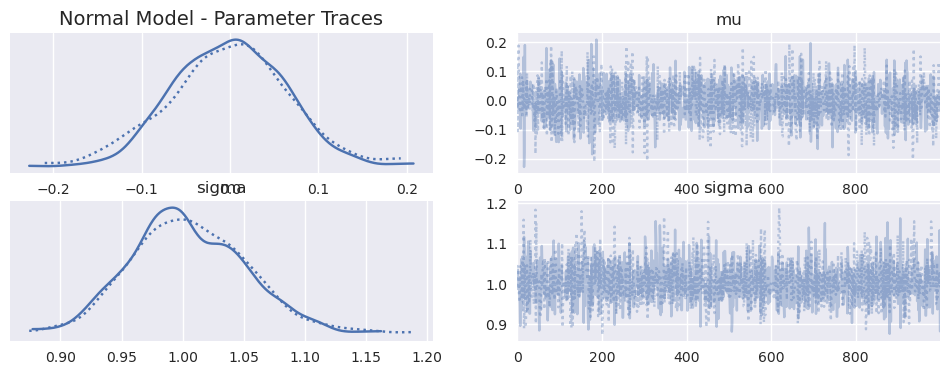

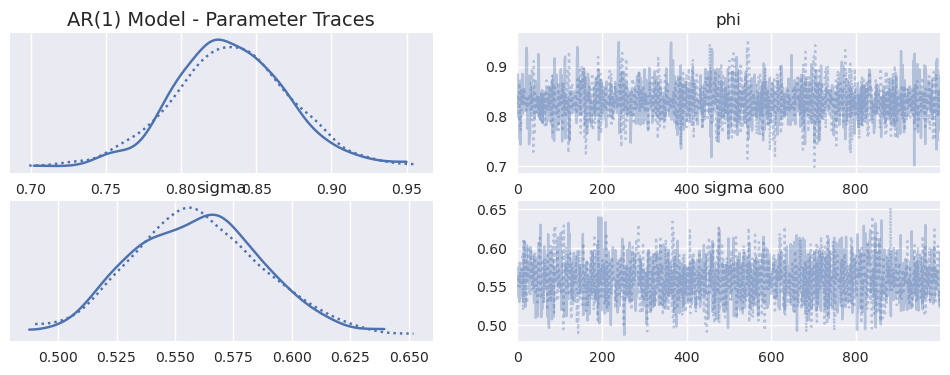

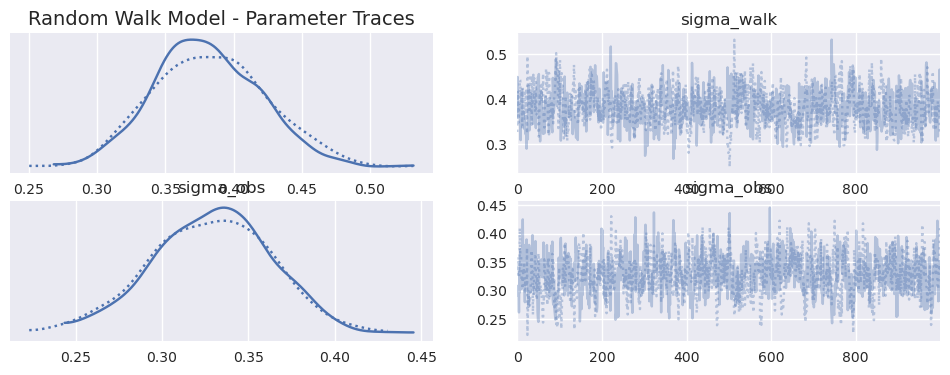


💡 **Trace Plot Interpretation**:
   • **Left panels**: Parameter values over iterations
   • **Right panels**: Marginal posterior distributions
   • **Good mixing**: Chains should overlap and explore the space efficiently
   • **Convergence**: Multiple chains should converge to same distribution


In [5]:
# Visualize trace plots for convergence assessment
# Create trace plots separately for each model
fig_normal = az.plot_trace(trace_normal, var_names=['mu', 'sigma'], figsize=(12, 4))
fig_normal[0, 0].set_title('Normal Model - Parameter Traces', fontsize=14)
plt.show()

fig_ar1 = az.plot_trace(trace_ar1, var_names=['phi', 'sigma'], figsize=(12, 4))
fig_ar1[0, 0].set_title('AR(1) Model - Parameter Traces', fontsize=14)
plt.show()

fig_rw = az.plot_trace(trace_rw, var_names=['sigma_walk', 'sigma_obs'], figsize=(12, 4))
fig_rw[0, 0].set_title('Random Walk Model - Parameter Traces', fontsize=14)
plt.show()

print("\n💡 **Trace Plot Interpretation**:")
print("   • **Left panels**: Parameter values over iterations")
print("   • **Right panels**: Marginal posterior distributions")
print("   • **Good mixing**: Chains should overlap and explore the space efficiently")
print("   • **Convergence**: Multiple chains should converge to same distribution")

## 2. Information Criteria for Model Comparison

Information criteria help us compare models by balancing fit quality with model complexity.

### WAIC vs LOO

- **WAIC (Widely Applicable Information Criterion)**: Approximates leave-one-out cross-validation
- **LOO (Leave-One-Out Cross-Validation)**: More robust but computationally intensive
- **Lower values indicate better models**

📊 **Model Comparison using Information Criteria**

**WAIC Comparison**:
              rank   elpd_waic      p_waic   elpd_diff        weight  \
AR(1) Model      0  119.945226  115.766336    0.000000  1.000000e+00   
Random Walk      1 -125.386058   88.285067  245.331284  2.464636e-10   
Normal Model     2 -325.316527    1.596117  445.261754  0.000000e+00   

                    se       dse  warning scale  
AR(1) Model   1.735759  0.000000     True   log  
Random Walk   6.882483  5.779275     True   log  
Normal Model  8.540209  8.610805    False   log  

**LOO Comparison**:
              rank    elpd_loo       p_loo   elpd_diff        weight  \
AR(1) Model      0   58.482390  177.229173    0.000000  1.000000e+00   
Random Walk      1 -142.754279  105.653288  201.236668  2.959423e-13   
Normal Model     2 -325.320058    1.599648  383.802448  0.000000e+00   

                    se       dse  warning scale  
AR(1) Model   3.783506  0.000000     True   log  
Random Walk   7.840872  6.560

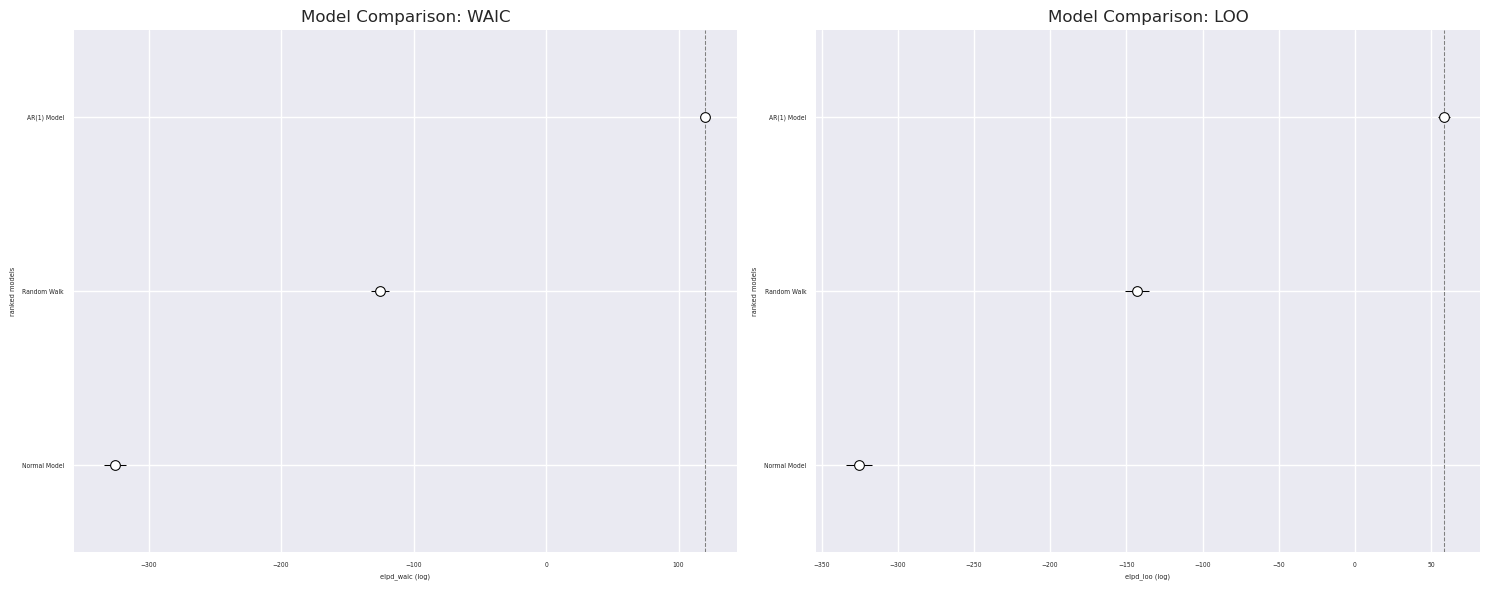


💡 **Interpretation**:
   • **Rank**: Lower rank = better model
   • **dWAIC/dLOO**: Difference from best model
   • **Weight**: Relative model probability
   • **SE**: Standard error of the difference


In [6]:
# Model comparison using information criteria
print("📊 **Model Comparison using Information Criteria**")
print("="*60)

# Compute WAIC and LOO for all models
comparison_waic = az.compare(models_traces, ic='waic')
comparison_loo = az.compare(models_traces, ic='loo')

print("\n**WAIC Comparison**:")
print(comparison_waic)

print("\n**LOO Comparison**:")
print(comparison_loo)

# Visualize model comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

az.plot_compare(comparison_waic, ax=ax1)
ax1.set_title('Model Comparison: WAIC')

az.plot_compare(comparison_loo, ax=ax2)
ax2.set_title('Model Comparison: LOO')

plt.tight_layout()
plt.show()

print("\n💡 **Interpretation**:")
print("   • **Rank**: Lower rank = better model")
print("   • **dWAIC/dLOO**: Difference from best model")
print("   • **Weight**: Relative model probability")
print("   • **SE**: Standard error of the difference")

## 3. Posterior Predictive Checks

Posterior predictive checks help us assess whether our models can reproduce key features of the observed data.

Sampling: [obs]


Output()

🔍 **Posterior Predictive Checks**


Sampling: [obs]


Output()

Sampling: [obs]


Output()

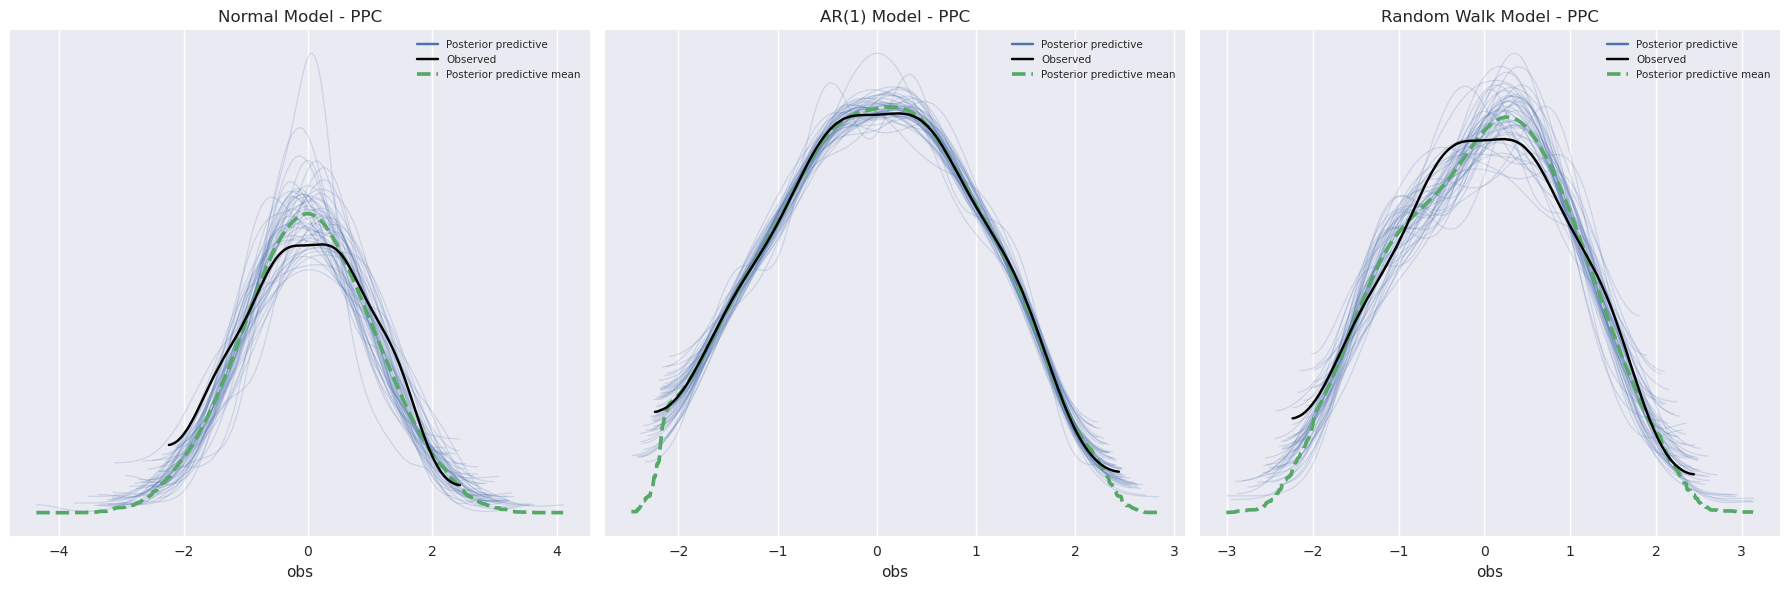


💡 **PPC Interpretation**:
   • **Blue line**: Observed data distribution
   • **Light blue**: Posterior predictive samples
   • **Good fit**: Observed data should be typical of predictive samples
   • **Poor fit**: Systematic deviations indicate model misspecification


In [7]:
# Posterior predictive checks for model validation
print("🔍 **Posterior Predictive Checks**")
print("="*40)

# Generate posterior predictive samples
with normal_model:
    ppc_normal = pm.sample_posterior_predictive(trace_normal, random_seed=RANDOM_SEED)

with ar1_model:
    ppc_ar1 = pm.sample_posterior_predictive(trace_ar1, random_seed=RANDOM_SEED)

with rw_model:
    ppc_rw = pm.sample_posterior_predictive(trace_rw, random_seed=RANDOM_SEED)

# Plot posterior predictive checks
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Normal model PPC
az.plot_ppc(ppc_normal, num_pp_samples=50, ax=axes[0])
axes[0].set_title('Normal Model - PPC')

# AR(1) model PPC
az.plot_ppc(ppc_ar1, num_pp_samples=50, ax=axes[1])
axes[1].set_title('AR(1) Model - PPC')

# Random walk model PPC
az.plot_ppc(ppc_rw, num_pp_samples=50, ax=axes[2])
axes[2].set_title('Random Walk Model - PPC')

plt.tight_layout()
plt.show()

print("\n💡 **PPC Interpretation**:")
print("   • **Blue line**: Observed data distribution")
print("   • **Light blue**: Posterior predictive samples")
print("   • **Good fit**: Observed data should be typical of predictive samples")
print("   • **Poor fit**: Systematic deviations indicate model misspecification")

## 4. Time Series-Specific Diagnostics

Time series models require additional diagnostics to check for temporal patterns in residuals.

📈 **Time Series-Specific Diagnostics**


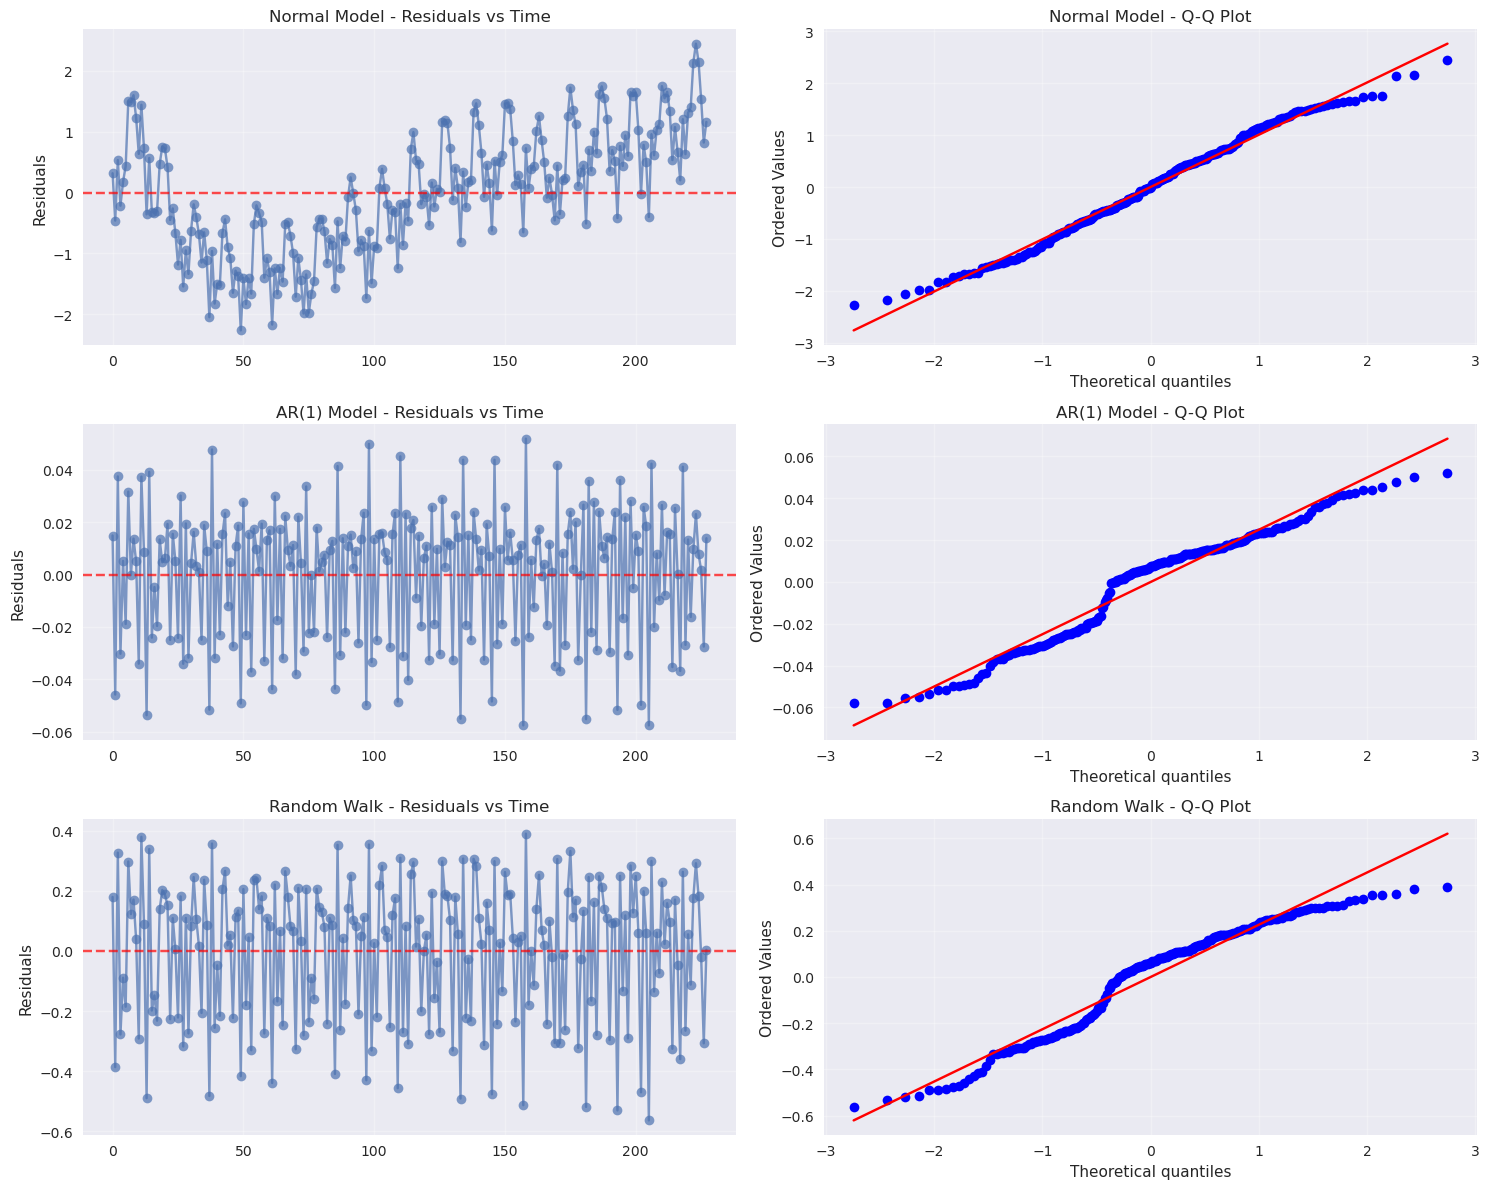


**Residual Autocorrelation (Lag 1)**:
   Normal Model: 0.8176 ❌
   AR(1) Model: -0.6603 ❌
   Random Walk: -0.3917 ❌

💡 **Residual Diagnostics Interpretation**:
   • **Time plot**: Should show no patterns or trends
   • **Q-Q plot**: Points should follow diagonal line for normality
   • **Autocorrelation**: Should be close to zero for good models


In [8]:
# Time series specific diagnostics
print("📈 **Time Series-Specific Diagnostics**")
print("="*45)

# Function to compute residuals
def compute_residuals(observed, predicted_samples):
    """Compute residuals from posterior predictive samples"""
    pred_mean = predicted_samples.mean(axis=0)
    return observed - pred_mean

# Compute residuals for each model
residuals_normal = compute_residuals(births_standardized, 
                                   ppc_normal.posterior_predictive['obs'].values.reshape(-1, n_obs))
residuals_ar1 = compute_residuals(births_standardized, 
                                ppc_ar1.posterior_predictive['obs'].values.reshape(-1, n_obs))
residuals_rw = compute_residuals(births_standardized, 
                               ppc_rw.posterior_predictive['obs'].values.reshape(-1, n_obs))

# Plot residual diagnostics
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

models_residuals = [
    ('Normal Model', residuals_normal),
    ('AR(1) Model', residuals_ar1),
    ('Random Walk', residuals_rw)
]

for i, (name, residuals) in enumerate(models_residuals):
    # Time series plot of residuals
    axes[i, 0].plot(residuals, 'o-', alpha=0.7)
    axes[i, 0].axhline(0, color='red', linestyle='--', alpha=0.7)
    axes[i, 0].set_title(f'{name} - Residuals vs Time')
    axes[i, 0].set_ylabel('Residuals')
    axes[i, 0].grid(True, alpha=0.3)
    
    # Q-Q plot for normality check
    stats.probplot(residuals, dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'{name} - Q-Q Plot')
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute autocorrelation of residuals
print("\n**Residual Autocorrelation (Lag 1)**:")
for name, residuals in models_residuals:
    if len(residuals) > 1:
        autocorr = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
        print(f"   {name}: {autocorr:.4f} {'✅' if abs(autocorr) < 0.1 else '❌'}")

print("\n💡 **Residual Diagnostics Interpretation**:")
print("   • **Time plot**: Should show no patterns or trends")
print("   • **Q-Q plot**: Points should follow diagonal line for normality")
print("   • **Autocorrelation**: Should be close to zero for good models")

## Summary and Best Practices

### Model Diagnostic Checklist

✅ **Convergence**:
- R-hat < 1.01 for all parameters
- ESS > 400 for reliable inference
- No divergent transitions

✅ **Model Fit**:
- Posterior predictive checks show good agreement
- Residuals show no systematic patterns
- Information criteria favor your model

✅ **Time Series Specific**:
- Residuals show no autocorrelation
- No obvious temporal patterns in residuals
- Model captures key data features (trend, seasonality)

### When Models Fail Diagnostics

- **Poor convergence**: Increase tune/draws, reparameterize, or use different sampler
- **Bad fit**: Add missing components (trend, seasonality, AR terms)
- **Residual patterns**: Consider more complex models or different distributions

**Next**: In Section 6, we'll use our validated models for forecasting and practical applications.

---

**Key Takeaways**:
- Always check convergence before interpreting results
- Use multiple criteria for model comparison
- Posterior predictive checks are essential for validation
- Time series models require specialized residual diagnostics
- Iterate and improve models based on diagnostic results